In [1]:
# visualization - compare with physics-based model (CAMS) + emission

import numpy as np
import random
import netCDF4 as nc
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [2]:
# read data
path_eac4 = "/HDD/global/EAC4_pm2p5_aod550/global_2019-2022.nc"
path_refer = "/HDD/global/refer/refer-{}.npy"
path_pred = "/DATA/global-emission-2-iniCAMS/start_{}/pred-{}.npy"
path_pred_new = "/DATA/global-emission-2_11-17_iniCAMS/start_{}/pred-{}.npy"
# path_pred_gfas = "/DATA/global-emission_gfas_2_11-17_iniCAMS/pred/start_{}/pred-{}.npy"
path_pred_gfas = "/DATA/global-emission-2_11-17_iniCAMS_iAOD/pred/start_{}/pred-{}.npy"
path_cams = "/DATA/CAMS/cams_resample/start_{}/cams-{}.npy"       #5-days-ahead prediction
path_fig = '/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures2_iAOD/'

# pred_list = {'pred': path_pred, 'pred_11-17': path_pred_new, 'cams': path_cams}
pred_list = {'pred_iAOD': path_pred_gfas, 'cams': path_cams}
labels = {'pred': 'PredNet', 'pred_11-17': 'PredNet_11-17', 'pred_iAOD': 'PredNet', 'cams': 'CAMS'}
colors = {'pred': 'C0', 'pred_11-17': 'C2', 'pred_iAOD': 'C0', 'cams': 'k'}

In [3]:
nc_file_eac4 = nc.Dataset(path_eac4)
times_nc = nc_file_eac4.variables['time']
nt = len(times_nc)
lon_eac4 = nc_file_eac4.variables['longitude'][:]
lat_eac4 = nc_file_eac4.variables['latitude'][:]
lon_eac4_grid, lat_eac4_grid = np.meshgrid(lon_eac4, lat_eac4)
print(lon_eac4_grid.shape)

# use data on 2018 for training and validation
dates_eac4 = nc.num2date(times_nc[:], times_nc.units, calendar=times_nc.calendar)
formated_dates_eac4 = [date.strftime('%Y-%m-%d %H:%M:%S') for date in dates_eac4]
print('training & validation:', formated_dates_eac4[0], '--', formated_dates_eac4[-1])

(241, 480)
training & validation: 2019-01-01 00:00:00 -- 2022-12-31 21:00:00


In [ ]:
# calculate mean and variance of PM2.5 and AOD550 prediciton over all available times
# since we are going to reuse CAMS preficiton for validation many times, 
# spatial resample and save it in a seperate file

start_date = datetime(2019, 1, 1, 0, 0)
end_date = datetime(2019, 12, 25, 23, 0)
time_interval = timedelta(hours=12)

start_list = []
current_date = start_date
while current_date <= end_date:
    start_list.append(current_date)
    current_date += time_interval

start_list = random.sample(start_list, 100)
n_start = len(start_list)
print(n_start)

n_ahead = 41
metrics_all = {}

for key, path_pred in pred_list.items():
    
    # initialize array to save matrics
    R = np.zeros((n_start, n_ahead, 2))
    RMSE = np.zeros((n_start, n_ahead, 2))

    for it in range(n_start):    
        start = start_list[it]
        
        for ahead in range(n_ahead):
            current = start + timedelta(hours=ahead*3)
            # reference
            filename = path_refer.format(current.strftime('%Y%m%d%H'))
            refer = np.load(filename)
            # cams prediction
            filename = path_pred.format(start.strftime('%Y%m%d%H'), current.strftime('%Y%m%d%H'))
            pred = np.load(filename)
            # metrics
            for i_feature in range(2):
                RMSE[it,ahead,i_feature] = np.sqrt(np.mean((refer[...,i_feature] - pred[...,i_feature])**2))
                R[it,ahead,i_feature] = (np.corrcoef(refer[...,i_feature].flatten(),pred[...,i_feature].flatten())[0, 1])

    metrics_all[key] = {'RMSE': RMSE, 'R': R}

100


pred_iAOD
cams
/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures2_iAOD/metrics_5days_ave_aod550_iAOD.png


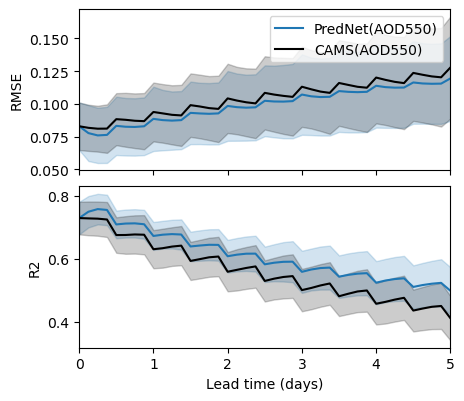

In [5]:
# PM2.5 prediction
# 1/4 page figure = 95 mm x 115 mm
# Full page = 190 mm x 230 mm
figure_width_mm = 115
figure_height_mm = 100
# Convert mm to inches
figure_width_inches = figure_width_mm / 25.4
figure_height_inches = figure_height_mm / 25.4

features = ['pm2p5', 'aod550']
titles = ['PM2.5', 'AOD550']
ylabels = ['RMSE ($ug/m3$)', 'RMSE']
scale = [1e9, 1]

fig, axs = plt.subplots(2, 1, figsize=(figure_width_inches, figure_height_inches), sharex=True)

x = np.arange(41)*3/24

index = 1
# axs[0].set_title(titles[index])

for key in pred_list:
    print(key)
    
    rmse_pred_mean = np.mean(metrics_all[key]['RMSE'], axis=0)
    rmse_pred_std = np.sqrt(np.var(metrics_all[key]['RMSE'], axis=0))
    y_mean = rmse_pred_mean[:,index]*scale[index]
    y_std = rmse_pred_std[:,index]*scale[index]
    axs[0].plot(x,y_mean, label=labels[key]+'({})'.format(titles[index]), color=colors[key])
    axs[0].fill_between(x, y_mean-y_std, y_mean+y_std, color=colors[key], alpha=0.2)  # Grey shaded variance
    axs[0].legend()
    
    r_pred_mean = np.mean(metrics_all[key]['R'], axis=0)
    r_pred_std = np.sqrt(np.var(metrics_all[key]['R'], axis=0))
    y_mean = r_pred_mean[:,index]
    y_std = r_pred_std[:,index]
    axs[1].plot(x,y_mean, color=colors[key])
    axs[1].fill_between(x, y_mean-y_std, y_mean+y_std, color=colors[key], alpha=0.2, label='Variance')  # Grey shaded variance
    
    axs[0].set_ylabel(ylabels[index])
    axs[1].set_ylabel('R2')

axs[1].set_xlabel('Lead time (days)')
axs[1].set_xlim(0,5)

plt.subplots_adjust(wspace=0.02, hspace=0.1, left=0.16, right=0.98, top=0.98, bottom=0.12)

filename = path_fig+ 'metrics_5days_ave_{}_iAOD.png'.format(features[index])
print(filename)
fig.savefig(filename, dpi=300)

plt.show()

pred_iAOD
cams
/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures2_iAOD/metrics_5days_ave_aod550_iAOD.png


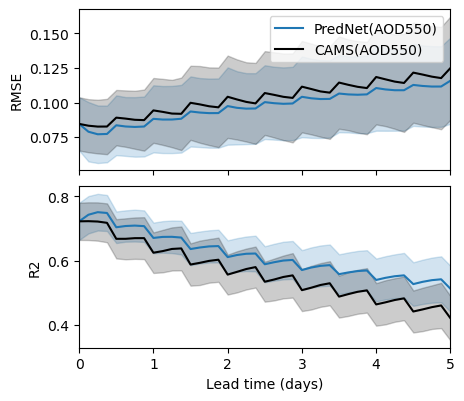

pred_iAOD
cams
/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures2_iAOD/metrics_5days_ave_pm2p5_iAOD.png


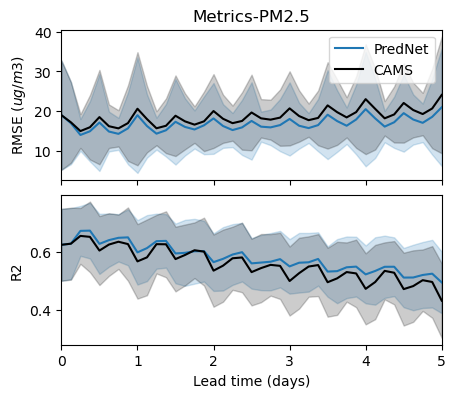